<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/main/emo_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# !pip install keras-tuner
# !git clone --branch utils https://github.com/ppkgtmm/sentiment.git sentiment

In [68]:
from sentiment.utils import read_data
import pandas as pd
import math
import matplotlib.pyplot as plt
import re
import nltk
from unicodedata import normalize
import collections

In [69]:
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [39]:
cols = ['text', 'emotions']

In [40]:
data = read_data('/content/drive/MyDrive/emotion/data/text_emo_tweet.csv', cols)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      50000 non-null  object
 1   emotions  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [42]:
data[['text']].describe().transpose()

,count,unique,top,freq
text,50000,49672,i expected hoped but being at unca has certain...,2


In [47]:
data.groupby('emotions').count().reset_index()

,emotions,text
0,anger,6923
1,fear,5635
2,joy,16982
3,love,4163
4,sadness,14553
5,surprise,1744


In [48]:
target_dist = data.groupby('emotions').count().reset_index()
target_dist['proportion'] = target_dist['text'] / sum(list(target_dist['text']))
target_dist

,emotions,text,proportion
0,anger,6923,0.13846
1,fear,5635,0.11270
2,joy,16982,0.33964
3,love,4163,0.08326
4,sadness,14553,0.29106
5,surprise,1744,0.03488


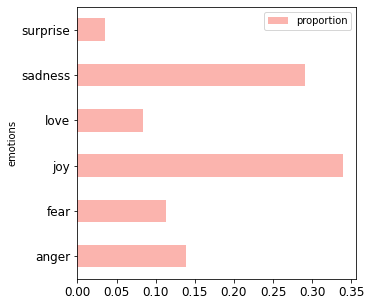

In [54]:
target_dist.plot(x='emotions', y='proportion', kind='barh', rot=0, \
                 colormap='Pastel1', fontsize=12, figsize=(5,5))

In [55]:
copy = data.copy()
copy['word_count'] = copy['text'].apply(lambda x: len(x.split(' ')))

In [58]:
def avg_word_length(text):
    words = text.split(' ')
    length = [len(w) for w in words]
    return math.ceil(sum(length) / len(length))

copy['avg_word_length'] = copy['text'].apply(avg_word_length)

In [59]:
copy.head(5)

,text,emotions,word_count,avg_word_length
0,i learned these past weeks and i confess to fe...,joy,23,5
1,i guess it just makes no sense to think that t...,joy,55,4
2,i shopped from the comfort of my sofa and mana...,joy,22,5
3,ive been feeling restless and im not sure why,fear,9,5
4,i was not feeling very long suffering,sadness,7,5


In [61]:
copy.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
word_count,50000.0,19.2701,11.015951,1.0,11.0,17.0,25.0,69.0
avg_word_length,50000.0,4.6057,0.649797,2.0,4.0,5.0,5.0,8.0


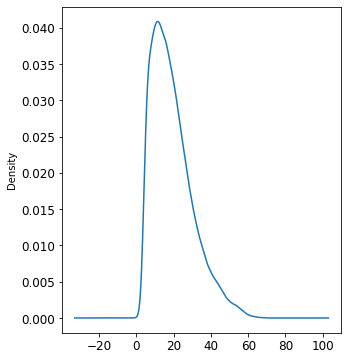

In [62]:
copy.word_count.plot(kind='kde', fontsize=12, figsize=(5,6))

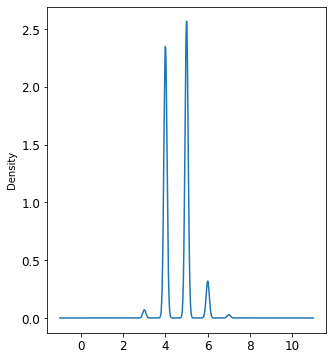

In [63]:
copy.avg_word_length.plot(kind='kde', fontsize=12, figsize=(5,6))

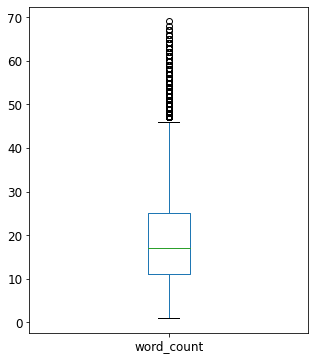

In [64]:
copy.word_count.plot(kind='box', fontsize=12, figsize=(5,6))

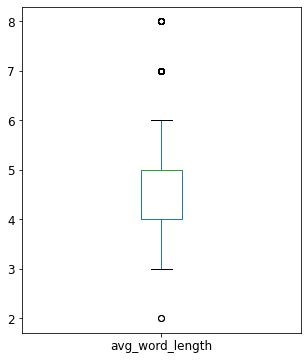

In [71]:
copy.avg_word_length.plot(kind='box', fontsize=12, figsize=(5,6))

In [72]:
word_counts = collections.Counter(" ".join(copy['text']).split())

In [73]:
count_df = pd.DataFrame(word_counts.most_common(20))
count_df.columns = ['word', 'count']
count_df['proportion'] = count_df['count'] / sum(list(count_df['count']))
count_df.head()

,word,count,proportion
0,i,81226,0.224408
1,feel,34787,0.096108
2,and,30085,0.083118
3,to,28260,0.078076
4,the,26249,0.072520


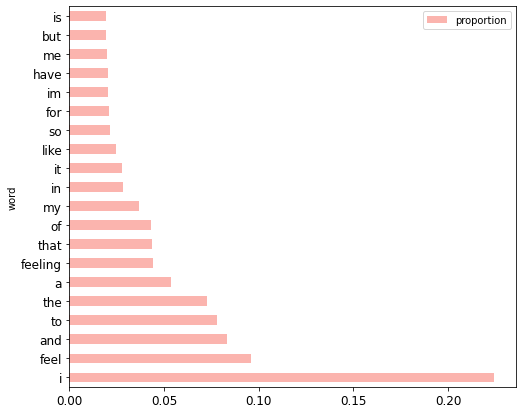

In [74]:
count_df.plot(kind='barh', x='word', y='proportion', rot=0, \
                 colormap='Pastel1', fontsize=12, figsize=(8,7))

In [65]:
reserved_words = ["EMAIL", "NUMBER", "MENTION", "URL"]
token_dict = {
            "ca": "can",
            "wo": "will",
            "sha": "shall",
            "'ve": "have",
            "'ll": "will",
            "'m": "am",
            "n't": "not",
            "'re": "are",
        }
word_dict = {
            "cant": "can not",
            "couldnt": "could not",
            "wont": "will not",
            "pls": "please",
            "plz": "please",
            "youre": "you are",
            "theyre": "they are",
            "ive": "I have",
            "havent": "have not",
            "hasnt": "has not",
            "hadnt": "had not",
            "im": "I am",
            "didnt": "did not",
            "dont": "do not",
            "doesnt": "does not",
            "gotta": "got to",
            "wanna": "want to",
            "gonna": "going to",
            "wannabe": "want to be",
            "cannot": "can not",
        }

In [66]:
def substitute(doc):
        doc = re.sub(r"<br />", " ", doc)
        doc = re.sub(r"\S+@\S+", " EMAIL ", doc)
        doc = re.sub(r"@\S+", " MENTION ", doc)
        doc = re.sub(r"https?:\S+|http?:\S+", " URL ", doc)
        doc = re.sub(r"(\d+\-\d+)|\d+", " NUMBER ", doc)
        doc = re.sub(r"[^A-Za-z']", " ", doc)

        return doc

def expand(token):
        if token in reserved_words:
            return token
        token = token.lower()
        if token.lower().strip() == "let's":
            return "let us"

        if token.lower().strip() == "'twas":
            return "it was"

        if word_dict.get(token, None):
            return word_dict.get(token)

        tokens = word_tokenize(token)
        if len(tokens) == 1:
            return word_dict.get(tokens[0], tokens[0])
        for i in range(len(tokens)):
            tokens[i] = token_dict.get(tokens[i], tokens[i])

        return " ".join(tokens)

def preprocess(doc):
        doc = normalize('NFD',doc).encode('ascii', 'ignore').decode('utf-8')
        doc = substitute(doc)
        tokens = doc.split()
        doc = " ".join([expand(w) for w in tokens])

        tokens = doc.split()
        tokens = [word for word in tokens if word.isalpha()]

        tokens = [
            word.lower() if word not in reserved_words else word for word in tokens
        ]

        return " ".join(tokens)

In [70]:
preprocess("😂 @mama124 Im gonna enter http:bit.ly.12673/ab \
for 30th time :| don't know why cant i České Budějovic á Ś cé")

'MENTION i am going to enter URL for NUMBER th time do not know why can not i ceske budejovic a s ce'

In [75]:
%%time 
copy['text'] = copy['text'].apply(preprocess)

CPU times: user 1min 4s, sys: 11.2 ms, total: 1min 4s
Wall time: 1min 4s
